# Planning-Lab Lesson 3: Markov Decision Process

In the third session we will work on the Markov decision process (MDP)

## Lava environments
The environments used are LavaFloor (visible in the figure) and its variations.

![Lava](images/lava.png)

The agent starts in cell $(0, 0)$ and has to reach the treasure in $(2, 3)$. In addition to the walls of the previous environments, the floor is covered with lava, there is a black pit of death.

Moreover, the agent can't comfortably perform its actions that instead have a stochastic outcome (visible in the figure):

![Dynact](images/dynact.png)

The action dynamics is the following:
- $P(0.8)$ of moving **in the desired direction**
- $P(0.1)$ of moving in a direction 90° with respect to the desired direction

Finally, since the floor is covered in lava, the agent receives a negative reward for each of its steps!

- -0.04 for each lava cell (L)
- -5 for the black pit (P). End of episode
- +1 for the treasure (G). End of episode

In [1]:
import os, sys, random
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

ModuleNotFoundError: No module named 'tqdm'

### Environment Properties 

In addition to the varables of the environments you have been using in the previous sessions, there are also a few more:

- $T$: matrix of the transition function $T(s, a, s') \rightarrow [0, 1]$
- $RS$: matrix of the reward function $R(s) \rightarrow \mathbb{R}$

The available actions are still Left, Right, Up, and Down.

#### Code Hints:

In [ ]:
env = gym.make("LavaFloor-v0")

current_state = env.pos_to_state(0, 0)
next_state = env.pos_to_state(0, 1)
goal_state = env.pos_to_state(2, 3)

print("Number of actions: ", env.action_space.n)
print("Actions: ", env.actions)
print("Reward of starting state:", env.RS[current_state])
print("Reward of goal state:", env.RS[goal_state])
print("Probability from (0, 0) to (1, 0) with action left:", env.T[current_state, 1, next_state])
print("Probability from (0, 0) to (2, 3) with action left:", env.T[current_state, 1, goal_state])

Number of actions:  4
Actions:  {0: 'L', 1: 'R', 2: 'U', 3: 'D'}
Reward of starting state: -0.04
Reward of goal state: 1.0
Probability from (0, 0) to (1, 0) with action left: 0.8
Probability from (0, 0) to (2, 3) with action left: 0.0


In [ ]:
env = gym.make("LavaFloor-v0")

current_state = env.pos_to_state(0, 0)
state = env.sample(current_state, 0)
print(state)

print(env.T[current_state, 0, state])
print(env.T[current_state, 1, state])
print(env.T[current_state, 2, state])
print(env.T[current_state, 3, state])

0
0.9
0.1
0.9
0.1


## Assignment 1: Value Iteration Algorithm

Your first assignment is to implement the Value Iteration algorithm on LavaFloor. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state. You can perform all the tests on different environment versions but with the same structure: *HugeLavaFloor*, *NiceLavaFloor*, and *VeryBadLavaFloor*.

<img src="images/value-iteration.png" width="600">

The *value_iteration* function has to be implemented. Notice that the value iteration approach returns a matrix with the value for each state, the function *values_to_policy* automatically converts this matrix into the policy.

In [ ]:
def value_iteration(environment, maxiters=300, discount=0.9, max_error=1e-3):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        maxiters: timeout for the iterations
        discount: gamma value, the discount factor for the Bellman equation
        max_error: the maximum error allowd in the utility of any state
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """

    # KEY IDEA : SOLVE ITERATIVELY VIA DYNAMIC PROGRAMMING -> iterate the Bellman update until convergence
    # N.B. studying the convergence to a value that tends to +inf we are guaranteed to find the optimal value for our problem
    # also we don't move to another state based on the weight of that node, but on a probability decided by us
    # Q(s, a) -> expected total reward for taking action a in the state s
    # V(s) -> maximum expected total reward starting from the state s (value function)
    # Q(s, a) = R(s, a) + gamma + sum_{s'}(P(s' | s, a) * V(s'))

    U_1 = [0] * environment.observation_space.n # vector of utilities for states S
    delta = 0 # maximum change in the utility o any state in an iteration
    U = U_1.copy()
    
    counter = 0
    
    # finche' il counter non raggiunge il massimo di iterazioni passate come parametro
    while counter < maxiters:
        # aggiorno il counter
        counter += 1
        # copio gli stati di utility per gli stati S su U
        U = U_1.copy()
        # massimi cambi nella utility di ogni stati in una iterazione
        delta = 0
        
        # per tutti gli stati presenti nel raggio d'azione
        for state in range(environment.observation_space.n):
            # creo un parametro per salvare la somma dei valori
            sum_value = []
            # doppio ciclo che rappresenta la sommatoria
            for action in range(environment.action_space.n):
                # aggiungo un valore in sum_value
                sum_value.append(0)
                
                for state_1 in range(environment.observation_space.n):
                    sum_value[action] += env.T[state, action, state_1] * U[state_1]
            # equivale a Q(s, a) = R(s, a) + gamma + sum_{s'}(P(s' | s, a) * V(s'))
            U_1[state] = environment.RS[state] + discount * max(sum_value)
            
            # controllo e riassegnamento di delta
            if abs(U_1[state] - U[state]) > delta:
                delta = abs(U_1[state] - U[state])
    
    return values_to_policy(np.asarray(U), env) # automatically convert the value matrix U to a policy

**The following code executes and Value Iteration and prints the resulting policy**

In [ ]:
env_name = "LavaFloor-v0"
#env_name = "HugeLavaFloor-v0"
#env_name = "NiceLavaFloor-v0"
#env_name = "VeryBadLavaFloor-v0"



env = gym.make(env_name)
print("\nENV RENDER:")
env.render()

t = timer()
policy = value_iteration(env)

print("\nEXECUTION TIME: \n{}".format(round(timer() - t, 4)))
policy_render = np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols))
results = CheckResult_L3(env_name, policy_render)
results.check_value_iteration()


ENV RENDER:
[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]

EXECUTION TIME: 
0.1244

#################################################################
#######  Environment: LavaFloor-v0 	Value Iteration  ########
#################################################################

===> Your solution is correct!

Policy:
[['D' 'L' 'L' 'U']
 ['D' 'L' 'L' 'L']
 ['R' 'R' 'R' 'L']]


## Assignment 2: Policy Iteration Algorithm

Your first assignment is to implement the Policy Iteration algorithm on LavaFloor. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state. You can perform all the tests on different environment versions but with the same structure: *HugeLavaFloor*, *NiceLavaFloor*, and *VeryBadLavaFloor*.

<img src="images/policy-iteration.png" width="600">

For the *policy evaluation step*, it is necessary to implement this function:

<img src="images/policy-evaluating.png" width="500">

**The following function has to be implemented:**

In [ ]:
def policy_iteration(environment, maxiters=150, discount=0.9, maxviter=10):
    """
    Performs the policy iteration algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        maxiters: timeout for the iterations
        discount: gamma value, the discount factor for the Bellman equation
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """

    # simile alla value iteration tranne per il fatto che il calcolo della optimal policy viene calcolato ad ogni step e non in modo piu' generale come la value iteration fa
    # e quindi e' piu' dispersiva e meno ottimizzata, anche se piu' precisa#
    
    policy = [0 for _ in range(environment.observation_space.n)] #initial policy
    U = [0 for _ in range(environment.observation_space.n)] #utility array

    unchanged = False
    count = 0
    while unchanged == False and count < maxiters:
        count += 1
        
        for state in range(environment.observation_space.n):
            U[state] = environment.RS[state]
            result = 0
            
            for state1 in range(environment.observation_space.n):
                result += environment.T[state, policy[state], state1] * U[state1]
                
            U[state] += discount * result
        
        unchanged = True
        
        for state in range(environment.observation_space.n):
            action_values = []
            for action in range(environment.action_space.n):
                action_values.append(0)
                for state1 in range(environment.observation_space.n):
                    action_values[action] += environment.T[state, action, state1] * U[state1]
            max_action_value = max(action_values)
            
            policy_value = 0
            for state1 in range(environment.observation_space.n):
                policy_value += environment.T[state, policy[state], state1] * U[state1]
            
            if max_action_value > policy_value:
                policy[state] = action_values.index(max_action_value)
                unchanged = False
            
    return np.asarray(policy)

**The following code executes and Value Iteration and prints the resulting policy**

In [ ]:
env_name = "LavaFloor-v0"
#env_name = "HugeLavaFloor-v0"
#env_name = "NiceLavaFloor-v0"
#env_name = "VeryBadLavaFloor-v0"

env = gym.make(env_name)
print("\nENV RENDER:")
env.render()

t = timer()
policy = policy_iteration(env)

print("\nEXECUTION TIME: \n{}".format(round(timer() - t, 4)))
policy_render = np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols))
results = CheckResult_L3(env_name, policy_render)
results.check_policy_iteration()


ENV RENDER:
[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]

EXECUTION TIME: 
0.0049

##################################################################
#######  Environment: LavaFloor-v0 	Policy Iteration  ########
##################################################################

===> Your solution is correct!

Policy:
[['D' 'L' 'L' 'U']
 ['D' 'L' 'L' 'L']
 ['R' 'R' 'R' 'L']]


## Comparison

The following code compares Value Iteration and Policy Iteration by plotting the accumulated rewards of each episode with iterations in the range $[1, 50]$ (might take a long time if not optimized via NumPy). You can perform all the tests on different environment versions but with the same structure: *HugeLavaFloor*.

The function **run_episode(environment, policy, max_iteration)** runs an episode on the given environment using the input policy.

Policy Iteration: 100%|████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 92.61it/s]


Execution time: 1.4267s


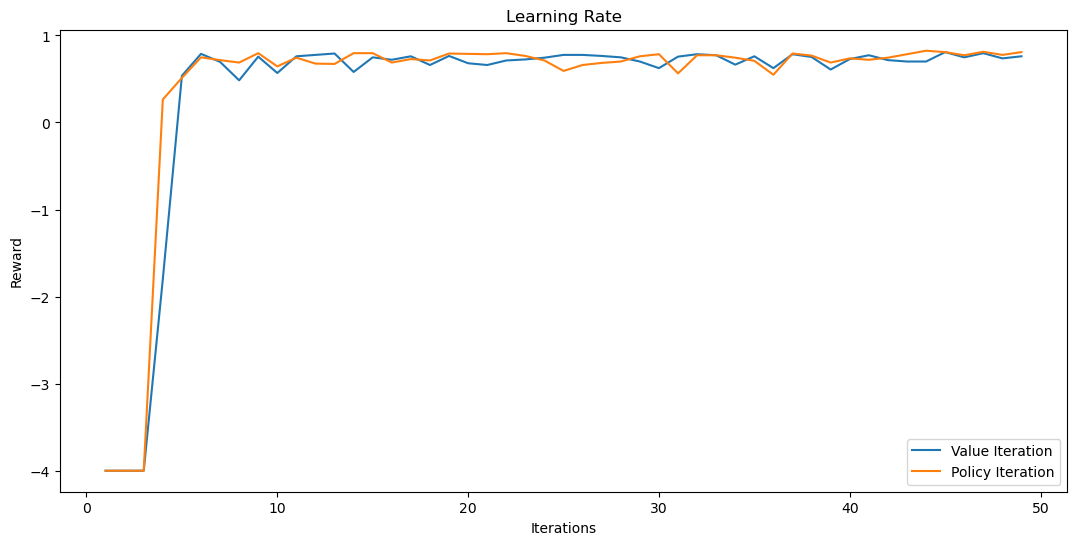

In [ ]:
env_name = "LavaFloor-v0"
#env_name = "HugeLavaFloor-v0"

maxiters = 49

env = gym.make(env_name)

series = []  # Series of learning rates to plot
liters = np.arange(maxiters + 1)  # Learning iteration values
liters[0] = 1
elimit = 100  # Limit of steps per episode
rep = 10  # Number of repetitions per iteration value
virewards = np.zeros(len(liters))  # Rewards array
c = 0

t = timer()

# Value iteration
for i in tqdm(liters, desc="Value Iteration", leave=True):
    reprew = 0
    policy = value_iteration(env, maxiters=i)  # Compute policy
        
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    virewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": virewards, "ls": "-", "label": "Value Iteration"})


vmaxiters = 5  # Max number of iterations to perform while evaluating a policy
pirewards = np.zeros(len(liters))  # Rewards array
c = 0

# Policy iteration
for i in tqdm(liters, desc="Policy Iteration", leave=True):
    reprew = 0
    policy = policy_iteration(env, maxiters=i)  # Compute policy
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    pirewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": pirewards, "ls": "-", "label": "Policy Iteration"})

print("Execution time: {0}s".format(round(timer() - t, 4)))
np.set_printoptions(linewidth=10000)

plot(series, "Learning Rate", "Iterations", "Reward")

Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend and the final convergence to an optimal solution.

**Standard Lava floor results comparison**
<img src="images/results-standard.png" width="600">

**Huge Lava floor results comparison** 
<img src="images/results-huge.png" width="600">